## Demonstration of DeepSruv-TF (Tensorflow version of DeepSurv)

### Tensorflow GPU setting

In [1]:
# Set environment variable
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # "0, 1" for multiple GPUs
# impoart tensorflow
import tensorflow as tf
print(tf.__version__)
# Allow growing memmory 
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

1.10.0


### Import DeepSurv packages

In [4]:
import sys
sys.path.append("deepsurv")
import deepsurv_tf
import deepsurv

### Import utility packages

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy
import seaborn as sns
import pandas

### Simulated (random) survival data

In [6]:
def generate_data(treatment_group = False):
    numpy.random.seed(123)
    sd = deepsurv.datasets.SimulatedData(5, num_features = 9,
        treatment_group = treatment_group)
    train_data = sd.generate_data(5000)
    valid_data = sd.generate_data(2000)
    test_data = sd.generate_data(2000)
    return train_data, valid_data, test_data

train, valid, test = generate_data(treatment_group=True)

[1. 0. 1. ... 1. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
[0. 1. 1. ... 1. 0. 1.]


### Train a deepsurv-tf model

In [7]:
epochs= 5000
params = deepsurv_tf.Parameters()
params.n_in = train['x'].shape[1]
params.n_epochs = epochs

ds_tf = deepsurv_tf.DeepSurvTF(params)
#stats = ds_tf.train(train, valid)
stats = ds_tf.train(train)

stats = pandas.concat([pandas.DataFrame(i) for i in stats.values()]).reset_index(drop = True)
stats = pandas.melt(stats, id_vars=["epochs", "type"])

Training done
Best epoch -1
Best loss inf


### Display training process
In the below graphs, "loss" is the negative likelihood, and "ci" is the concordance index.

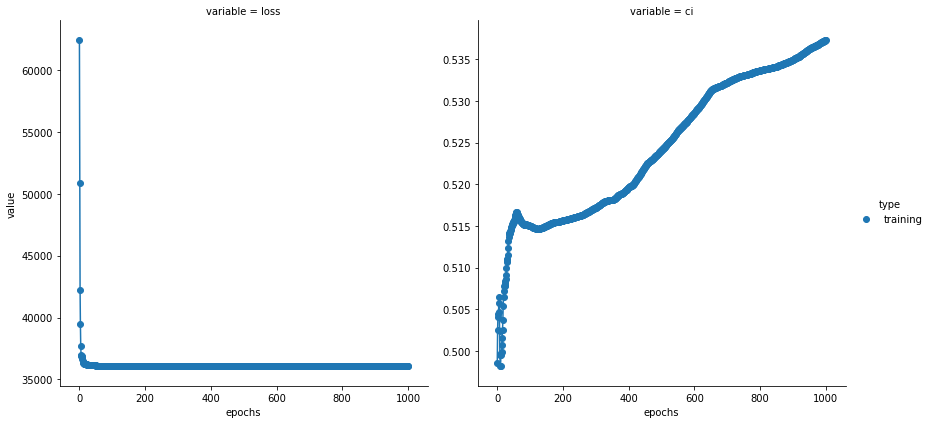

In [6]:
sns.FacetGrid(data=stats, hue="type", col="variable", sharey=False, height=6) \
    .map(plt.plot, "epochs", "value") \
    .map(plt.scatter, "epochs", "value") \
    .add_legend()

### Run deepsurv-theanos (diabled for now)

In [7]:
# hyperparams = {
#     'n_in': 10,
#     'learning_rate': 1e-5,
#     'hidden_layers_sizes': [10,10]
# }

# network = deepsurv.DeepSurv(**hyperparams)
# network.restored_update_params = False
# log = network.train(train, valid, n_epochs=epochs)


In [8]:
# fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,6))
# ax1.plot(log["train"], label = "training loss")
# ax1.set_ylabel("Loss")
# ax2.set_ylabel("CI")
# ax2.plot(log["train_ci"], label = "training ci")


## Effect of network configuration

### Hidden layers

a
Training done
Best epoch 60
Best loss 12750.612
b
Training done
Best epoch 50
Best loss 12748.971
c
Training done
Best epoch 10
Best loss 12748.396
d
Training done
Best epoch 30
Best loss 12748.784


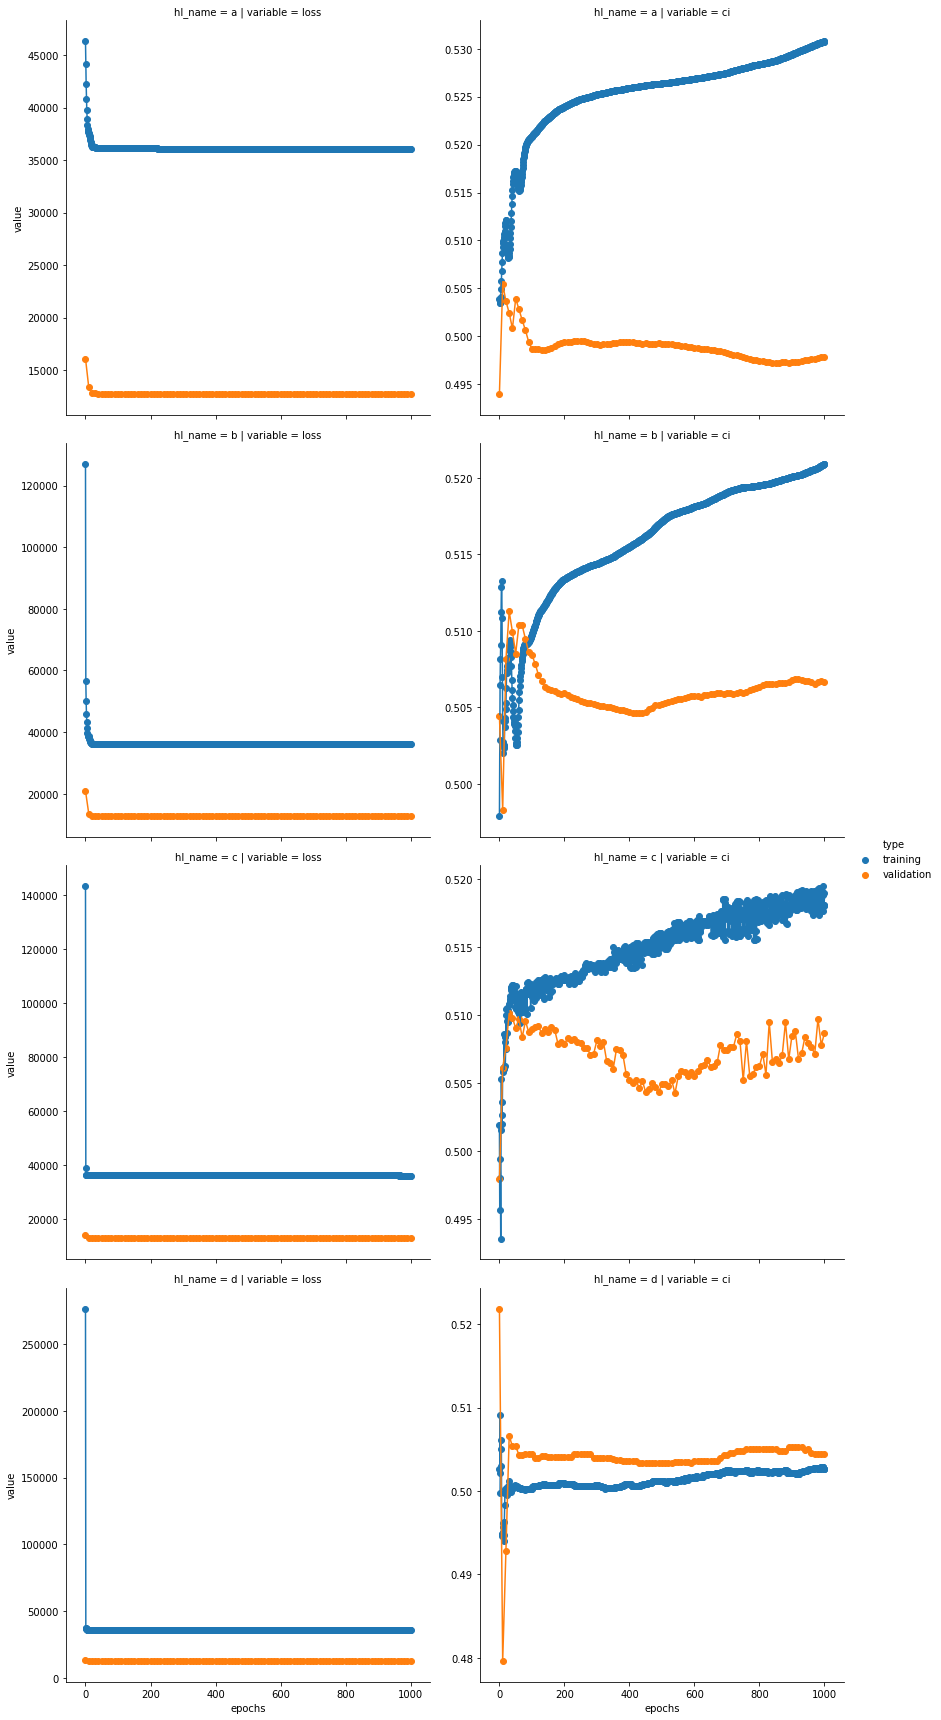

In [9]:
hidden_layers = {
    "a": [10], 
    "b": [10]*2,##repeat 10, 2 times
    "c": [5]*4,##repeat 5, 10 times
    "d": [10,5,8,3]
}

all_stats = []
for name, hl in hidden_layers.items():
    print(name)
    params = deepsurv_tf.Parameters()
    params.n_in = train['x'].shape[1]
    params.n_epochs = epochs
    params.hidden_layers_sizes = hl
    
    ds_tf = deepsurv_tf.DeepSurvTF(params)
    stats = ds_tf.train(train, valid)
    
    stats = pandas.concat([pandas.DataFrame(i) for i in stats.values()]).reset_index(drop = True)
    stats = pandas.melt(stats, id_vars=["epochs","type"])
    stats["hl_name"] = name
    
    all_stats.append(stats)
    
stats = pandas.concat(all_stats)

sns.FacetGrid(data= stats,hue = "type", col="variable", row = "hl_name", sharey=False, height=6) \
    .map(plt.plot, "epochs", "value") \
    .map(plt.scatter, "epochs", "value") \
    .add_legend()

### L2 regularizations

a
Training done
Best epoch 70
Best loss 12756.855
b
Training done
Best epoch 100
Best loss 12750.3125
c
Training done
Best epoch 100
Best loss 12748.78


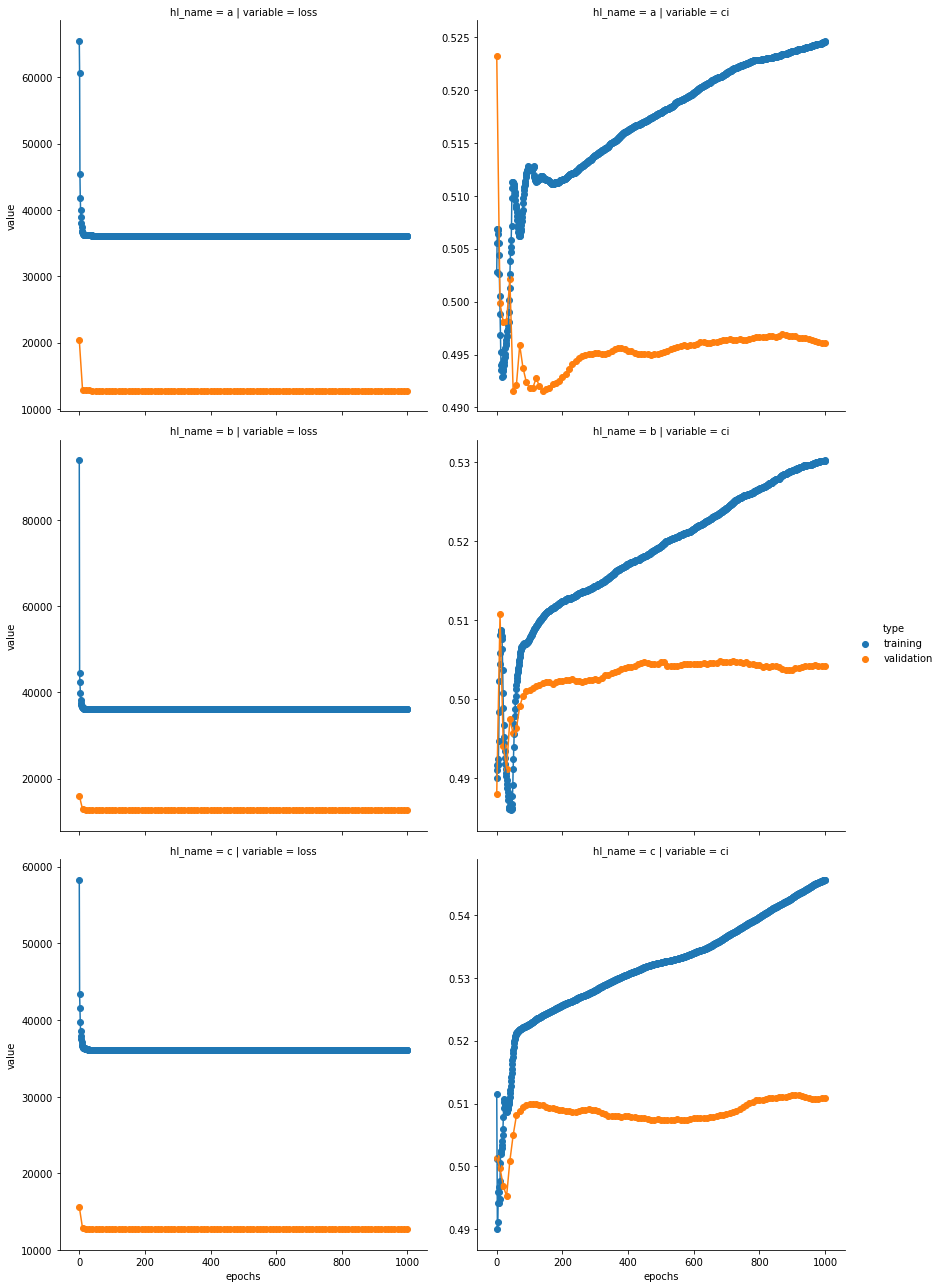

In [10]:
regularisations = {
    "a":0.1,
    "b":0.01,
    "c":0.001
}

all_stats = []
for name, hl in regularisations.items():
    print(name)
    params = deepsurv_tf.Parameters()
    params.n_in = train['x'].shape[1]
    params.n_epochs = epochs
    params.L2_reg = hl
    
    ds_tf = deepsurv_tf.DeepSurvTF(params)
    stats = ds_tf.train(train, valid)
    
    stats = pandas.concat([pandas.DataFrame(i) for i in stats.values()]).reset_index(drop = True)
    stats = pandas.melt(stats, id_vars=["epochs","type"])
    stats["hl_name"] = name
    
    all_stats.append(stats)
    
stats = pandas.concat(all_stats)

sns.FacetGrid(data= stats,hue = "type", col="variable", row = "hl_name", sharey=False, height=6) \
    .map(plt.plot, "epochs", "value") \
    .map(plt.scatter, "epochs", "value") \
    .add_legend()

### Drop out

a
Training done
Best epoch 180
Best loss 12745.981
b
Training done
Best epoch 190
Best loss 12751.238
c
Training done
Best epoch 30
Best loss 12749.84


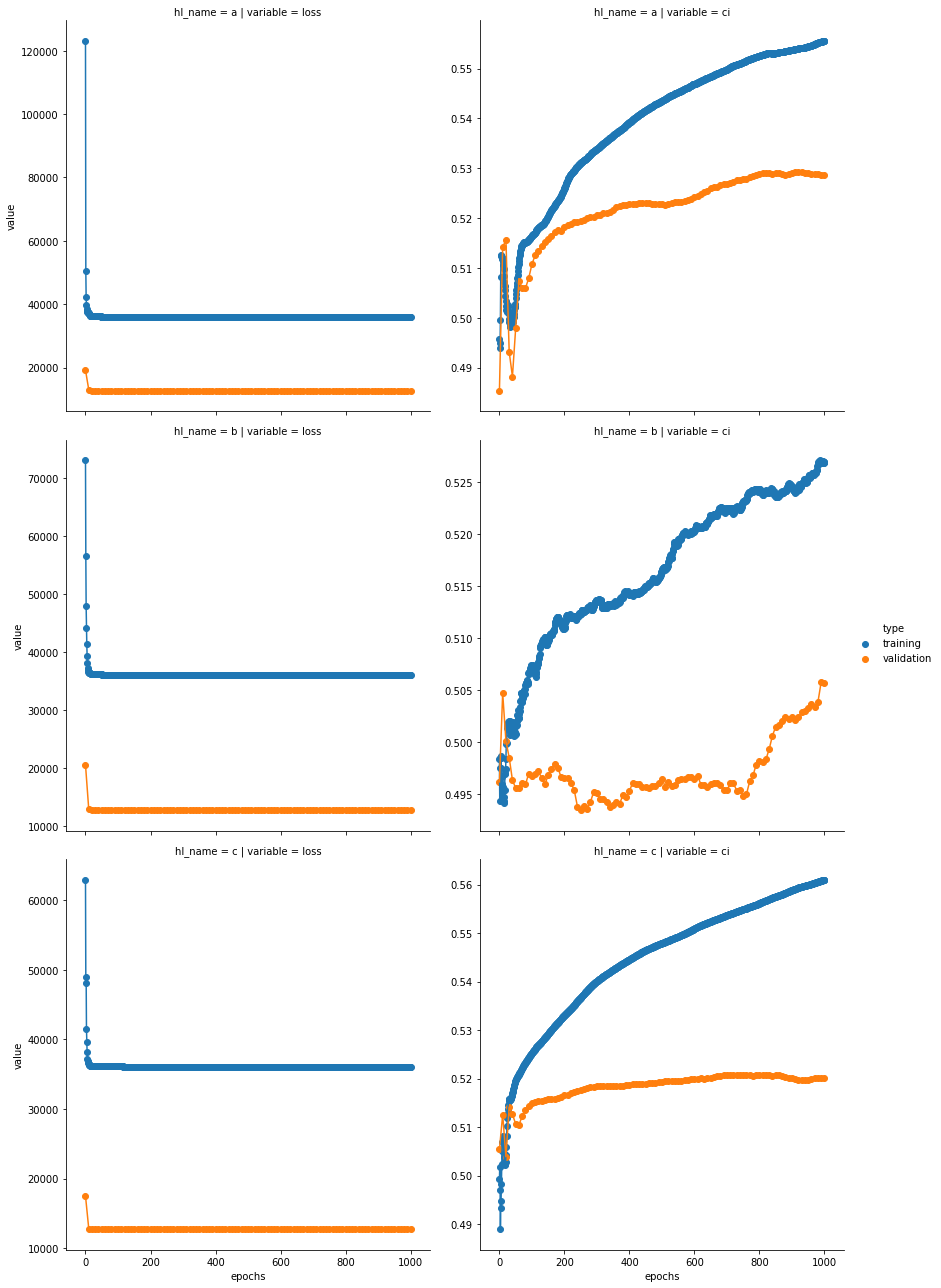

In [11]:
drop_out = {
    "a": None,
    "b": 0.4,
    "c": 0.8
}

all_stats = []
for name, hl in drop_out.items():
    print(name)
    params = deepsurv_tf.Parameters()
    params.n_in = train['x'].shape[1]
    params.n_epochs = epochs
    params.L2_reg = 0 #switching off other regularisations
    params.drop_out = hl
    
    ds_tf = deepsurv_tf.DeepSurvTF(params)
    stats = ds_tf.train(train, valid)
    
    stats = pandas.concat([pandas.DataFrame(i) for i in stats.values()]).reset_index(drop = True)
    stats = pandas.melt(stats, id_vars=["epochs","type"])
    stats["hl_name"] = name
    
    all_stats.append(stats)
    
stats = pandas.concat(all_stats)

sns.FacetGrid(data= stats,hue = "type", col="variable", row = "hl_name", sharey=False, height=6) \
    .map(plt.plot, "epochs", "value") \
    .map(plt.scatter, "epochs", "value") \
    .add_legend()

### batch norm

a
Training done
Best epoch 160
Best loss 12749.369
b
Training done
Best epoch 110
Best loss 12755.012


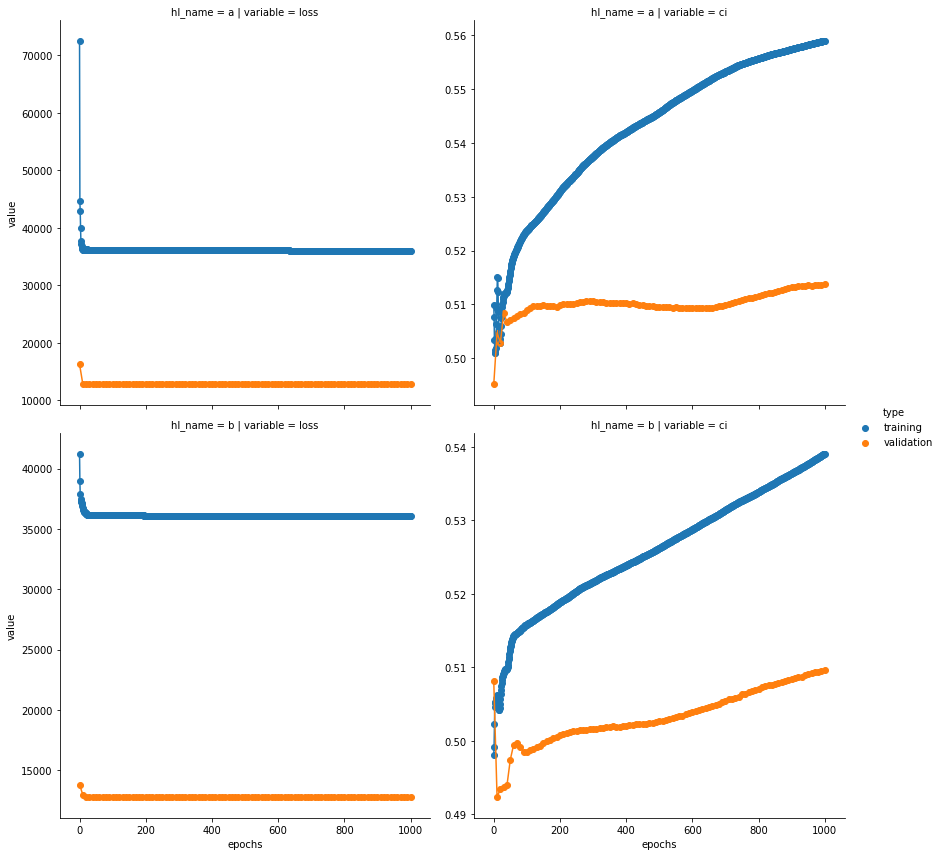

In [12]:
batch_norm = {
    "a": None,
    "b": True
}

all_stats = []
for name, hl in batch_norm.items():
    print(name)
    params = deepsurv_tf.Parameters()
    params.n_in = train['x'].shape[1]
    params.n_epochs = epochs
    params.batch_norm = hl
    
    ds_tf = deepsurv_tf.DeepSurvTF(params)
    stats = ds_tf.train(train, valid)
    
    stats = pandas.concat([pandas.DataFrame(i) for i in stats.values()]).reset_index(drop = True)
    stats = pandas.melt(stats, id_vars=["epochs","type"])
    stats["hl_name"] = name
    
    all_stats.append(stats)
    
stats = pandas.concat(all_stats)

sns.FacetGrid(data= stats,hue = "type", col="variable", row = "hl_name", sharey=False, height=6) \
    .map(plt.plot, "epochs", "value") \
    .map(plt.scatter, "epochs", "value") \
    .add_legend()